[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Pyrcel/example_basic_run.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Pyrcel/example_basic_run.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Pyrcel/example_basic_run.ipynb)

#### based on Example Figure from Pyrcel code documentation https://pyrcel.readthedocs.io/en/latest/examples/basic_run.html

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import numpy as np
from matplotlib import pyplot
from scipy.ndimage import uniform_filter1d
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si
from PySDM.initialisation.spectra import Lognormal
from PySDM.products import (
    ParcelDisplacement, AmbientTemperature, AmbientRelativeHumidity,
    ParticleSizeSpectrumPerVolume, ParticleVolumeVersusRadiusLogarithmSpectrum
)

from PySDM_examples.Pyrcel import Settings, Simulation

In [ ]:
settings = Settings(
    dz = 1 * si.m,
    n_sd_per_mode = (5, 5),
    aerosol_modes_by_kappa = {
        .54: Lognormal(
            norm_factor=850 / si.cm ** 3,
            m_mode=15 * si.nm,
            s_geom=1.6
        ),
        1.2: Lognormal(
            norm_factor=10 / si.cm ** 3,
            m_mode=850 * si.nm,
            s_geom=1.2
        )
    },
    vertical_velocity = 1.0 * si.m / si.s,
    initial_pressure = 775 * si.mbar,
    initial_temperature = 274 * si.K,
    initial_relative_humidity = .98,
    displacement = 250 * si.m,
    formulae = Formulae(constants={'MAC': .3})
)

dry_radius_bin_edges = np.logspace(
    np.log10(1e-3 * si.um),
    np.log10(5e0 * si.um),
    33, endpoint=False
)

simulation = Simulation(settings, products=(
    ParcelDisplacement(
        name='z'),
    AmbientRelativeHumidity(
        name='S_max_percent', unit='%', var='RH'),
    AmbientTemperature(
        name='T'),
    ParticleSizeSpectrumPerVolume(
        name='dry:dN/dR', radius_bins_edges=dry_radius_bin_edges, dry=True),
    ParticleVolumeVersusRadiusLogarithmSpectrum(
        name='dry:dV/dlnR', radius_bins_edges=dry_radius_bin_edges, dry=True),
))

In [4]:
output = simulation.run()

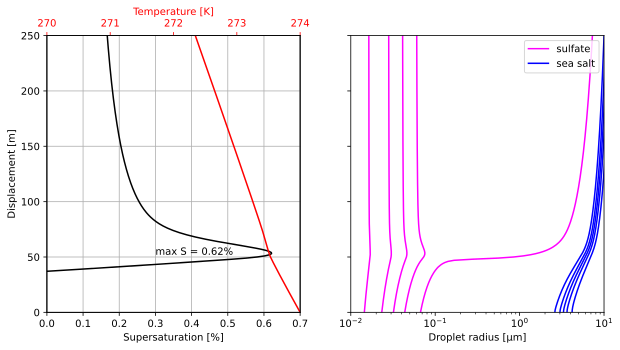

In [7]:
fig, axs = pyplot.subplots(1, 2, sharey=True, figsize=(10, 5))

axS = axs[0]
axS.plot(np.asarray(output['products']['S_max_percent'])-100, output['products']['z'], color='black')
axS.set_ylabel('Displacement [m]')
axS.set_xlabel('Supersaturation [%]')
axS.set_xlim(0, 0.7)
axS.set_ylim(0, 250)
axS.text(0.3, 52, f"max S = {np.nanmax(output['products']['S_max_percent'])-100:.2f}%")
axS.grid()

axT = axS.twiny()
axT.xaxis.label.set_color('red')
axT.tick_params(axis='x', colors='red')
axT.plot(output['products']['T'], output['products']['z'], color='red')
rng = (270, 274)
axT.set_xlim(*rng)
axT.set_xticks(np.linspace(*rng, num=5))
axT.set_xlabel('Temperature [K]')

axR = axs[1]
axR.set_xscale('log')
axR.set_xlim(1e-2, 1e1)
for drop_id, volume in enumerate(output['attributes']['volume']):
    axR.plot(
        settings.formulae.trivia.radius(volume=np.asarray(volume)) / si.um,
        output['products']['z'],
        color='magenta' if drop_id < settings.n_sd_per_mode[0] else 'blue',
        label='sulfate' if drop_id == 0 else 'sea salt' if drop_id == settings.n_sd_per_mode[0] else ''
    )
axR.legend(loc='upper right')
axR.set_xlabel('Droplet radius [μm]')

show_plot("supersaturation.pdf")

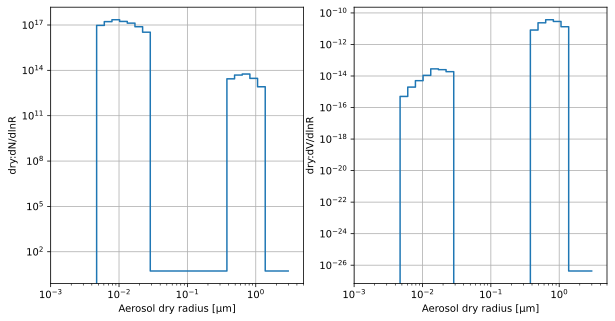

HTML(value="<a href='./size_dist.pdf' target='_blank'>./size_dist.pdf</a><br>")

In [6]:
fig, axs = pyplot.subplots(1, 2, figsize=(10, 5), sharex=True)
for i, name in enumerate(["dry:dN/dR","dry:dV/dlnR",]):
    spec = output['products'][name][0]
    if name.endswith("/dR"):
        spec /= np.diff(np.log(dry_radius_bin_edges))
        name = name.replace('/dR', '/dlnR')
    axs[i].step(
        dry_radius_bin_edges[:-1] / si.um,
        uniform_filter1d(spec, size=3),
        where='pre'
    )
    axs[i].set_ylabel(name)
    axs[i].set_xlabel("Aerosol dry radius [μm]")
    axs[i].grid()
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
pyplot.xlim(1e-3, 5e0)

show_plot("size_dist.pdf")